# Convert and Optimize YOLOv11 keypoint detection model with OpenVINO™

Keypoint detection/Pose is a task that involves detecting specific points in an image or video frame. These points are referred to as keypoints and are used to track movement or pose estimation. YOLOv11 can detect keypoints in an image or video frame with high accuracy and speed.


This tutorial demonstrates step-by-step instructions on how to run and optimize [PyTorch YOLOv11 Pose model](https://docs.ultralytics.com/tasks/pose/) with OpenVINO. We consider the steps required for keypoint detection scenario.  You can find more details about model on [model page](https://docs.ultralytics.com/models/yolo11/) in Ultralytics documentation.

The tutorial consists of the following steps:
- Prepare the PyTorch model.
- Download and prepare a dataset.
- Validate the original model.
- Convert the PyTorch model to OpenVINO IR.
- Validate the converted model.
- Prepare and run optimization pipeline.
- Compare performance of the FP32 and quantized models.
- Compare accuracy of the FP32 and quantized models.
- Live demo


#### Table of contents:

- [Get PyTorch model](#Get-PyTorch-model)
    - [Prerequisites](#Prerequisites)
- [Instantiate model](#Instantiate-model)
    - [Convert model to OpenVINO IR](#Convert-model-to-OpenVINO-IR)
    - [Verify model inference](#Verify-model-inference)
    - [Select inference device](#Select-inference-device)
    - [Test on single image](#Test-on-single-image)
- [Optimize model using NNCF Post-training Quantization API](#Optimize-model-using-NNCF-Post-training-Quantization-API)
    - [Validate Quantized model inference](#Validate-Quantized-model-inference)
- [Compare the Original and Quantized Models](#Compare-the-Original-and-Quantized-Models)
    - [Compare performance of the Original and Quantized Models](#Compare-performance-of-the-Original-and-Quantized-Models)
- [Other ways to optimize model](#Other-ways-to-optimize-model)
- [Live demo](#Live-demo)
    - [Run Keypoint Detection on video](#Run-Keypoint-Detection-on-video)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/yolov11-optimization/yolov11-keypoint-detection.ipynb" />


## Get PyTorch model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv11 nano model (also known as `yolo11n-pose`) pre-trained on a COCO dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other Ultralytics models.
Typical steps to obtain a pre-trained model:
1. Create an instance of a model class.
2. Load a checkpoint state dict, which contains the pre-trained model weights.
3. Turn the model to evaluation for switching some operations to inference mode.

In this case, the creators of the model provide an API that enables converting the YOLOv11 model to OpenVINO IR. Therefore, we do not need to do these steps manually.

#### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install necessary packages.

In [1]:
import platform


if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"


%pip install -q "openvino>=2025.1.0" "nncf>=2.16.0"
%pip install -q "protobuf==3.20.*" "torch>=2.1" "torchvision>=0.16" "ultralytics==8.3.142" tqdm opencv-python --extra-index-url https://download.pytorch.org/whl/cpu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvid

Import required utility functions.
The lower cell will download the `notebook_utils` Python module from GitHub.

In [2]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file, VideoPlayer, device_widget, quantization_widget

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("yolov11-keypoint-detection.ipynb")

In [8]:
# Download a test sample
IMAGE_PATH = Path("/content/test/images/86b23b486e494691a1499eb89e8847-8996-2891-1646553488_jpg.rf.0cc631c936abdd766ecae3b09e925645.jpg")

'''if not IMAGE_PATH.exists():
    download_file(
        url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/intel_rnb.jpg",
        filename=IMAGE_PATH.name,
        directory=IMAGE_PATH.parent,
    )'''

'if not IMAGE_PATH.exists():\n    download_file(\n        url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/intel_rnb.jpg",\n        filename=IMAGE_PATH.name,\n        directory=IMAGE_PATH.parent,\n    )'

In [4]:
!unzip traffic\ sign\ dataset.zip

Archive:  traffic sign dataset.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/004_jpg.rf.0d8f34537c6cb17858cedae52d892a63.jpg  
 extracting: test/images/007_jpg.rf.03fd51f8521393ddd9ddbcf9352817f2.jpg  
 extracting: test/images/007_jpg.rf.4fc0e194a78f498e2105f2b4afe3f883.jpg  
 extracting: test/images/009_jpg.rf.f8416de45b02ceea07ca222f71678182.jpg  
 extracting: test/images/011_jpg.rf.4d8ba3d75fcda9ae408051c82d266382.jpg  
 extracting: test/images/014_jpg.rf.9df0a1778fafa4baa4e734e137753dc0.jpg  
 extracting: test/images/018_jpg.rf.75388bbc87121c2d71743269ff9ef7a7.jpg  
 extracting: test/images/023_jpg.rf.579bc85f72492086d12baa1db0dc08d3.jpg  
 extracting: test/images/030_jpg.rf.b8be6b4fb2e25db6b4b1f89d39dafa9f.jpg  
 extracting: test/images/031_jpg.rf.106b44219d8517cd593d99d7f8d8af55.jpg  
 extracting: test/images/034_jpg.rf.079ad665b83ff641c6b8

## Instantiate model
[back to top ⬆️](#Table-of-contents:)

For loading the model, required to specify a path to the model checkpoint. It can be some local path or name available on models hub (in this case model checkpoint will be downloaded automatically).

Making prediction, the model accepts a path to input image and returns list with Results class object. Results contains boxes and key points. Also it contains utilities for processing results, for example, `plot()` method for drawing.

Let us consider the examples:

In [10]:
import ipywidgets as widgets

model_id = [
    "yolo11n-pose",
    "yolo11s-pose",
    "yolo11m-pose",
    "yolo11l-pose",
    "yolo11x-pose",
    "yolov8n-pose",
    "yolov8s-pose",
    "yolov8m-pose",
    "yolov8l-pose",
    "yolov8x-pose",
    "bestv11",
]

model_name = widgets.Dropdown(options=model_id, value=model_id[0], description="Model")

model_name

Dropdown(description='Model', options=('yolo11n-pose', 'yolo11s-pose', 'yolo11m-pose', 'yolo11l-pose', 'yolo11…


image 1/1 /content/test/images/86b23b486e494691a1499eb89e8847-8996-2891-1646553488_jpg.rf.0cc631c936abdd766ecae3b09e925645.jpg: 640x640 1 cam re phai, 17.3ms
Speed: 2.4ms preprocess, 17.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


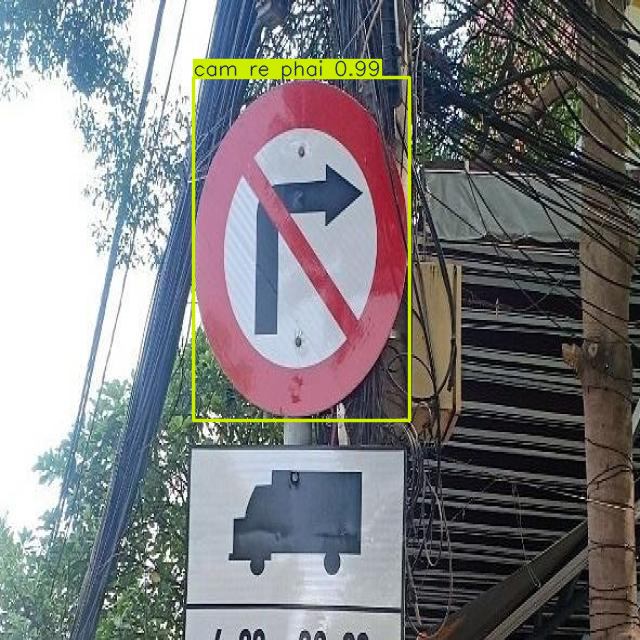

In [11]:
from PIL import Image
from ultralytics import YOLO

POSE_MODEL_NAME = model_name.value

pose_model = YOLO(f"bestv11.pt")
label_map = pose_model.model.names

res = pose_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

### Convert model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

Ultralytics provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we can preserve dynamic shapes in the model.

In [12]:
# object detection model
pose_model_path = Path(f"{POSE_MODEL_NAME}_openvino_model/{POSE_MODEL_NAME}.xml")
if not pose_model_path.exists():
    pose_model.export(format="openvino", dynamic=True, half=True)

Ultralytics 8.3.142 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'bestv11.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 33, 8400) (5.2 MB)

OpenVINO: starting export with openvino 2025.1.0-18503-6fec06580ab-releases/2025/1...
OpenVINO: export success ✅ 4.4s, saved as 'bestv11_openvino_model/' (5.4 MB)

Export complete (5.0s)
Results saved to /content
Predict:         yolo predict task=detect model=bestv11_openvino_model imgsz=640 half 
Validate:        yolo val task=detect model=bestv11_openvino_model imgsz=640 data=/content/data.yaml half 
Visualize:       https://netron.app


### Verify model inference
[back to top ⬆️](#Table-of-contents:)

We can reuse the base model pipeline specifying Intel devices (intel:gpu, intel:npu, intel:cpu) when running inference with OpenVINO.

### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO

In [15]:
device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Test on single image
[back to top ⬆️](#Table-of-contents:)

Now, once we have defined preprocessing and postprocessing steps, we are ready to check model prediction.

In [16]:
pose_model = YOLO(pose_model_path.parent, task="pose")

res = pose_model(IMAGE_PATH, device=f"intel:{device.value.lower()}")
Image.fromarray(res[0].plot()[:, :, ::-1])

Loading bestv11_openvino_model for OpenVINO inference...
WARNING ⚠️ OpenVINO device 'AUTO' not available. Using 'AUTO' instead.
Using OpenVINO LATENCY mode for batch=1 inference...



TypeError: Value after * must be an iterable, not NoneType

Great! The result is the same, as produced by original models.

## Check model accuracy on the dataset
[back to top ⬆️](#Table-of-contents:)

For comparing the optimized model result with the original, it is good to know some measurable results in terms of model accuracy on the validation dataset.


### Download the validation dataset
[back to top ⬆️](#Table-of-contents:)

YOLOv8 is pre-trained on the COCO dataset, so to evaluate the model accuracy we need to download it. According to the instructions provided in the YOLOv8 repo, we also need to download annotations in the format used by the author of the model, for use with the original model evaluation function.

>**Note**: The initial dataset download may take a few minutes to complete. The download speed will vary depending on the quality of your internet connection.

## Optimize model using NNCF Post-training Quantization API
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv8.

The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize OpenVINO IR model, using the `openvino.save_model` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [17]:
import openvino as ov

core = ov.Core()
pose_ov_model = core.read_model(pose_model_path)

int8_model_pose_path = Path(f"{POSE_MODEL_NAME}_openvino_model_int8/{POSE_MODEL_NAME}.xml")
quantized_pose_model = None

to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [18]:
# Fetch skip_kernel_extension module
if not Path("skip_kernel_extension.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

Reuse validation dataloader in accuracy testing for quantization.
For that, it should be wrapped into the `nncf.Dataset` object and define a transformation function for getting only input tensors.

In [19]:
%%skip not $to_quantize.value

import nncf

from zipfile import ZipFile

from ultralytics.data.utils import DATASETS_DIR
from ultralytics.utils import DEFAULT_CFG
from ultralytics.cfg import get_cfg
from ultralytics.data.utils import check_det_dataset
from ultralytics.models.yolo.pose import PoseValidator
from ultralytics.utils.metrics import OKS_SIGMA

if not int8_model_pose_path.exists():

    DATA_URL = "https://ultralytics.com/assets/coco8-pose.zip"
    CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/v8.1.0/ultralytics/cfg/datasets/coco8-pose.yaml"

    OUT_DIR = DATASETS_DIR

    DATA_PATH = "/content/traffic sign dataset.zip"
    CFG_PATH = "/content/data.yaml"

    if not (OUT_DIR / "coco8-pose/labels").exists():
        #download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
        #download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)
        with ZipFile(DATA_PATH, "r") as zip_ref:
            zip_ref.extractall(OUT_DIR)

    args = get_cfg(cfg=DEFAULT_CFG)
    args.data = "coco8-pose.yaml"

    pose_validator = PoseValidator(args=args)
    pose_validator.data = check_det_dataset(args.data)
    pose_validator.stride = 32
    pose_data_loader = pose_validator.get_dataloader(OUT_DIR / "coco8-pose", 1)

    pose_validator.is_coco = True
    pose_validator.names = label_map
    pose_validator.metrics.names = pose_validator.names
    pose_validator.nc = 1
    pose_validator.sigma = OKS_SIGMA


    def transform_fn(data_item:dict):
        """
        Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
        Parameters:
           data_item: Dict with data item produced by DataLoader during iteration
        Returns:
            input_tensor: Input data for quantization
        """
        input_tensor = pose_validator.preprocess(data_item)['img'].numpy()
        return input_tensor


    quantization_dataset = nncf.Dataset(pose_data_loader, transform_fn)

val2017.zip:   0%|          | 0.00/334k [00:00<?, ?B/s]

coco8-pose.yaml:   0%|          | 0.00/552 [00:00<?, ?B/s]

100%|██████████| 755k/755k [00:00<00:00, 25.6MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1143.3±529.9 MB/s, size: 38.9 KB)



val: Scanning /content/datasets/coco8-pose/labels/train... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 1166.54it/s]

val: New cache created: /content/datasets/coco8-pose/labels/train.cache


The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset.
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided. YOLOv8 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achieve a better result, we will use a `mixed` quantization preset. It provides symmetric quantization of weights and asymmetric quantization of activations. For more accurate results, we should keep the operation in the postprocessing subgraph in floating point precision, using the `ignored_scope` parameter.

>**Note**: Model post-training quantization is time-consuming process. Be patient, it can take several minutes depending on your hardware.

In [ ]:
%%skip not $to_quantize.value

import openvino as ov

core = ov.Core()
pose_ov_model = core.read_model(pose_model_path)


if not int8_model_pose_path.exists():

    ignored_scope = nncf.IgnoredScope(  # post-processing
        subgraphs=[
            nncf.Subgraph(inputs=[f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat",
                                  f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_1",
                                  f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_2",
                                 f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_7"],
                          outputs=[f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_9"])
        ]
    )

    # Detection model
    quantized_pose_model = nncf.quantize(
        pose_ov_model,
        quantization_dataset,
        preset=nncf.QuantizationPreset.MIXED,
        ignored_scope=ignored_scope
    )
    print(f"Quantized keypoint detection model will be saved to {int8_model_pose_path}")
    ov.save_model(quantized_pose_model, str(int8_model_pose_path))

### Validate Quantized model inference
[back to top ⬆️](#Table-of-contents:)

`nncf.quantize` returns the OpenVINO Model class instance, which is suitable for loading on a device for making predictions. `INT8` model input data and output result formats have no difference from the floating point model representation. Therefore, we can reuse the same `detect` function defined above for getting the `INT8` model result on the image.

In [ ]:
%%skip not $to_quantize.value

display(device)

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

Ultralytics 8.3.142 🚀 Python-3.10.12 torch-2.7.0+cpu CPU (Intel Core(TM) i9-10980XE 3.00GHz)
Loading yolo11n-pose_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 /home/maleksandr/test_notebooks/yolo-device/openvino_notebooks/notebooks/yolov11-optimization/data/intel_rnb.jpg: 480x640 1 person, 16.9ms
Speed: 2.1ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


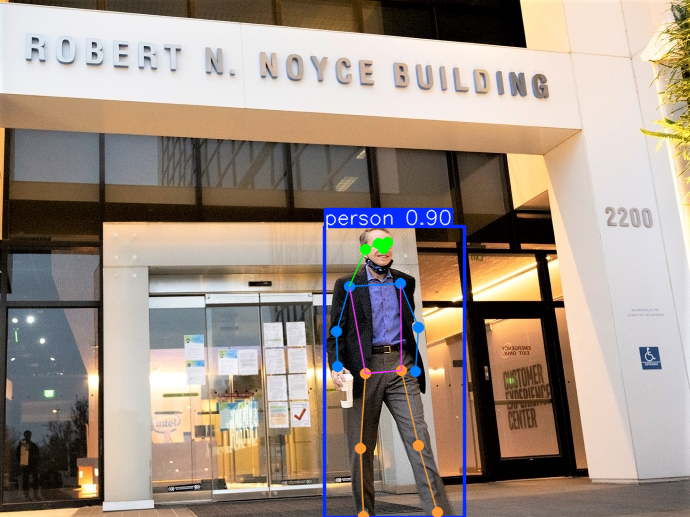

In [ ]:
%%skip not $to_quantize.value
if quantized_pose_model is None:
    quantized_pose_model = core.read_model(int8_model_pose_path)

ov_config = {}
quantized_pose_model.reshape({0: [1, 3, 480, 640]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
quantized_pose_compiled_model = core.compile_model(quantized_pose_model, device.value, ov_config)

pose_model = YOLO(pose_model_path.parent, task="pose")

if pose_model.predictor is None:
    custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
    args = {**pose_model.overrides, **custom}
    pose_model.predictor = pose_model._smart_load("predictor")(overrides=args, _callbacks=pose_model.callbacks)
    pose_model.predictor.setup_model(model=pose_model.model)

pose_model.predictor.model.ov_compiled_model = quantized_pose_compiled_model

res = pose_model(IMAGE_PATH)
display(Image.fromarray(res[0].plot()[:, :, ::-1]))

## Compare the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)


### Compare performance of the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)
Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) to measure the inference performance of the `FP32` and `INT8` models.

> **Note**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m <model_path> -d CPU -shape "<input_shape>"` to benchmark async inference on CPU on specific input data shape for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [ ]:
%%skip not $to_quantize.value

device

In [ ]:
if int8_model_pose_path.exists():
    # Inference FP32 model (OpenVINO IR)
    !benchmark_app -m $pose_model_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 19.95 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.23/aten::cat/Concat_9) : f32 / [...] / [?,56,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch si

In [ ]:
if int8_model_pose_path.exists():
    # Inference INT8 model (OpenVINO IR)
    !benchmark_app -m $int8_model_pose_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2025.1.0-18503-6fec06580ab-releases/2025/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 51.01 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.23/aten::cat/Concat_9) : f32 / [...] / [?,56,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch si

### Compare accuracy of the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)

As we can see, there is no significant difference between `INT8` and float model result in a single image test. To understand how quantization influences model prediction precision, we can compare model accuracy on a dataset.

## Other ways to optimize model
[back to top ⬆️](#Table-of-contents:)

The performance could be also improved by another OpenVINO method such as async inference pipeline or preprocessing API.

Async Inference pipeline help to utilize the device more optimal. The key advantage of the Async API is that when a device is busy with inference, the application can perform other tasks in parallel (for example, populating inputs or scheduling other requests) rather than wait for the current inference to complete first. To understand how to perform async inference using openvino, refer to [Async API tutorial](../async-api/async-api.ipynb)

Preprocessing API enables making preprocessing a part of the model reducing application code and dependency on additional image processing libraries.
The main advantage of Preprocessing API is that preprocessing steps will be integrated into the execution graph and will be performed on a selected device (CPU/GPU etc.) rather than always being executed on CPU as part of an application. This will also improve selected device utilization. For more information, refer to the overview of [Preprocessing API tutorial](../optimize-preprocessing/optimize-preprocessing.ipynb). To see, how it could be used with YOLOV8 object detection model , please, see [Convert and Optimize YOLOv8 real-time object detection with OpenVINO tutorial](./yolov8-object-detection.ipynb)

## Live demo
[back to top ⬆️](#Table-of-contents:)

The following code runs model inference on a video:

In [ ]:
import collections
import time
from IPython import display
import cv2
import numpy as np


def run_keypoint_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=pose_model,
    device=device.value,
):
    player = None

    ov_config = {}
    model.reshape({0: [1, 3, 384, 640]})
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}
    compiled_model = core.compile_model(model, device, ov_config)

    if pose_model.predictor is None:
        custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
        args = {**seg_model.overrides, **custom}
        pose_model.predictor = pose_model._smart_load("predictor")(overrides=args, _callbacks=pose_model.callbacks)
        pose_model.predictor.setup_model(model=pose_model.model)

    pose_model.predictor.model.ov_compiled_model = compiled_model

    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results
            input_image = np.array(frame)

            start_time = time.time()

            detections = pose_model(input_image, verbose=False)
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run Keypoint Detection on video
[back to top ⬆️](#Table-of-contents:)


In [ ]:
# VIDEO_SOURCE = 0 #for webcam
VIDEO_URL = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4"
VIDEO_SOURCE = Path("people.mp4")

if not VIDEO_SOURCE.exists():
    download_file(VIDEO_URL)

In [ ]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

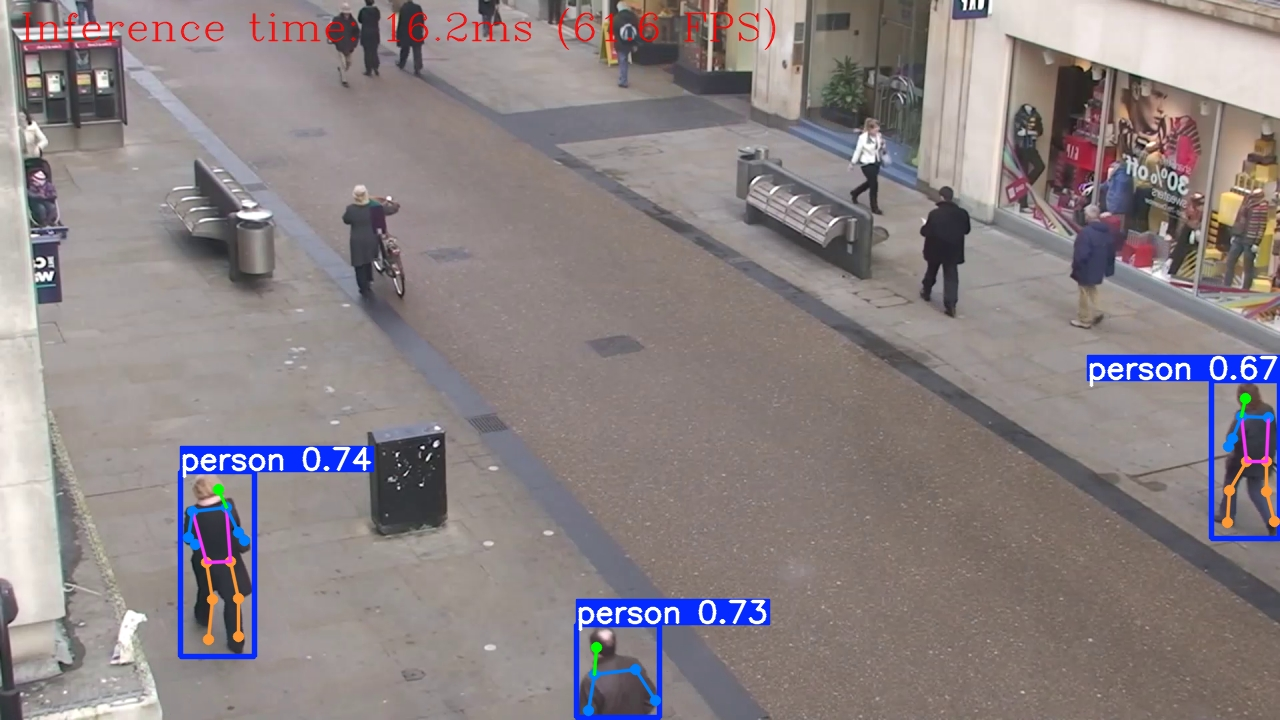

Source ended


In [ ]:
run_keypoint_detection(
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
    model=pose_ov_model,
    device=device.value,
)